Original bounds: [  46.71404219 -773.2397324   752.73481518    0.        ]
First coordinate: (192.0319818967435, -609.8380983809839)


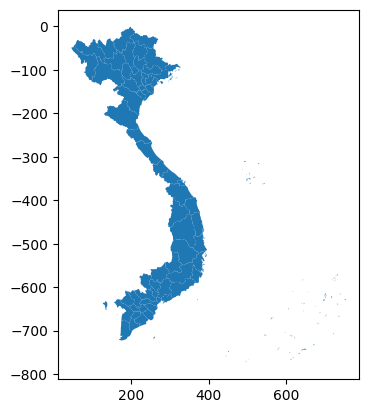

In [16]:
import geopandas as gpd 


vn_map = gpd.read_file("vn_map.json")
vn_map['geometry'] = vn_map['geometry'].scale(xfact=1, yfact=-1, origin=(0,0))
print("Original bounds:", vn_map.total_bounds)
print("First coordinate:", vn_map.geometry.iloc[0].exterior.coords[0])

# Check current CRS
# print(f"Current CRS: {vn_map.crs}")

vn_map = vn_map.rename(columns={'ten_tinh': 'Province'})
vn_map.plot()
geo_pro_names = vn_map['Province'].unique()

# These values are way outside valid latitude/longitude ranges —
# Longitude should be between –180 and +180
# Latitude should be between –90 and +90

# This usually happens when:
# The file was exported from QGIS or ArcGIS using a projected CRS (e.g., UTM meters),
# But Plotly expects coordinates in EPSG:4326 (longitude/latitude degrees).

# GeoPandas thinks your data is already in longitude–latitude (WGS84). But your coordinates clearly aren’t degrees.
# Those 192, -609 values look like projected coordinates in meters (probably from a Vietnam local projection, like UTM Zone 48N or 49N).


# Solution: You need to manually assign the correct CRS first, then reproject.
vn_map.set_crs("EPSG:32649", allow_override=True).to_crs(epsg=4326).to_file("vn_map_crs.json", driver="GeoJSON")

In [18]:
gdf = gpd.read_file("vn_map_crs.json")


# Get the actual bounds
bounds = gdf.total_bounds  # [min_lon, min_lat, max_lon, max_lat]
print(f"Actual bounds: {bounds}")

# Add some padding (e.g., 10% on each side)
lon_padding = (bounds[2] - bounds[0]) * 0.1
lat_padding = (bounds[3] - bounds[1]) * 0.1

min_lon = bounds[0] - lon_padding
min_lat = bounds[1] - lat_padding
max_lon = bounds[2] + lon_padding
max_lat = bounds[3] + lat_padding

print(f"With padding: lon [{min_lon:.2f}, {max_lon:.2f}], lat [{min_lat:.3f}, {max_lat:.3f}]")

Actual bounds: [ 1.06511675e+02 -6.97418241e-03  1.06518000e+02  0.00000000e+00]
With padding: lon [106.51, 106.52], lat [-0.008, 0.001]


In [36]:
import pandas as pd 

data = pd.read_csv("vn_population.csv", index_col=False)
data.drop(columns=['Unnamed: 0'])
pop_pro_names = data['Province'].unique()

In [37]:
set(geo_pro_names) - set(pop_pro_names)

{'Bình Dương',
 'Hoà Bình',
 'Khánh Hoà',
 'Lạng Sơn',
 'TP.Hồ Chí Minh',
 'Thanh Hoá'}

In [38]:
set(pop_pro_names) - set(geo_pro_names)

{'Bình Duong',
 'Hòa Bình',
 'Khánh Hòa',
 'Lạng Son',
 'TP. Hồ Chí Minh',
 'Thanh Hóa'}

In [39]:
data.loc[data['Province'] == 'Bình Duong', 'Province'] = 'Bình Dương'
data.loc[data['Province'] == 'TP. Hồ Chí Minh', 'Province'] = 'TP.Hồ Chí Minh'
data.loc[data['Province'] == 'Lạng Son', 'Province'] = 'Lạng Sơn'
vn_map.loc[vn_map['Province'] == 'Hoà Bình', 'Province'] = 'Hòa Bình'
vn_map.loc[vn_map['Province'] == 'Khánh Hoà', 'Province'] = 'Khánh Hòa'
vn_map.loc[vn_map['Province'] == 'Thanh Hoá', 'Province'] = 'Thanh Hóa'

In [43]:
geo_pro_names = vn_map['Province'].unique()
pop_pro_names = data['Province'].unique()
print(set(pop_pro_names) - set(geo_pro_names))
print(set(geo_pro_names) - set(pop_pro_names))

set()
set()


In [ ]:
vn_map.to_file("vn_map.json", driver="GeoJSON")
data.to_csv("vn_population.csv")